In [1]:

import os
import torch
import gc
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import albumentations as A
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
!gdown https://drive.google.com/u/0/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s


Downloading...
From (original): https://drive.google.com/u/0/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s
From (redirected): https://drive.google.com/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s&confirm=t&uuid=e0bcec76-87f0-4f3a-8b5b-f0678230fae7
To: /content/maps.zip
100% 252M/252M [00:01<00:00, 190MB/s]


In [3]:
!7z x maps.zip



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 251592154 bytes (240 MiB)

Extracting archive: maps.zip
 93% 4096 Open              --
Path = maps.zip
Type = zip
Physical Size = 251592154

  0%      6% 314 - maps/train/951.jpg                              12% 638 - maps/train/128.jpg                              18% 920 - maps/train/886.jpg                              24% 1204 - maps/train/1070.jpg                                30% 1465 - __MACOSX/maps/train/._496.jpg

In [4]:
!ls maps


train  val


In [5]:
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path)
        width, height = image.size
        half_width = width // 2
        left_image = image.crop((0, 0, half_width, height))
        right_image = image.crop((half_width, 0, width, height))

        if self.transform:
            transformed = self.transform(image=np.array(left_image), image0=np.array(right_image))
            left_image, right_image = transformed['image'], transformed['image0']

        return left_image, right_image


In [6]:
# # [-1, 1]
# def normalize(x, **kwargs):
#     return ((x / 127.5) - 1).astype(np.float32)

# # [-1, 1]
# def denormalize(x, **kwargs):
#     # return torch.clamp((x + 1) * 255 / 2, 0, 255).to(torch.uint8)
#     return torch.clamp(((x * 255.0) + 255) / 2, 0, 255).to(torch.uint8)

[0, 1]
def normalize(x, **kwargs):
    return (x / 255.0).astype(np.float32)

[0, 1]
def denormalize(x, **kwargs):
    return torch.clamp(x * 255, 0, 255).to(torch.uint8)

# https://albumentations.ai/docs/api_reference/augmentations/
transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate(limit=40),
    A.Lambda(image=normalize),
    ToTensorV2(),
], additional_targets={'image0': 'image'})


In [7]:

train_path = 'maps/train'
valid_path = 'maps/val'
dataset_train = ImageFolderDataset(folder_path=train_path, transform=transform)
dataset_valid = ImageFolderDataset(folder_path=valid_path, transform=transform)

train_batch_size = 4
valid_batch_size = 4

dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=valid_batch_size, shuffle=False)
        # Extract and display the first 4 right images
def get_first_4_right_images(dataloader):
    right_images_list = []
    for batch_idx, (left_images, right_images) in enumerate(dataloader_train):
        right_images_list.extend(right_images)
        if len(right_images_list) >= 4:
            break
    return right_images_list[:4]

# Example usage
right_images_list = get_first_4_right_images(dataloader_train)
right_images_np = [img.to(device) for img in right_images_list]

In [8]:

def show_images3(left_images, center_images, right_images, title=None):
    fig, axes = plt.subplots(len(left_images), 3, figsize=(7.5, 5))
    for i, (left_img, center_img, right_img) in enumerate(zip(left_images, center_images, right_images)):
        left_img = left_img.permute(1, 2, 0)
        center_img = center_img.permute(1, 2, 0)
        right_img = right_img.permute(1, 2, 0)
        axes[i, 0].imshow(left_img)
        axes[i, 1].imshow(center_img)
        axes[i, 2].imshow(right_img)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    if title is not None:
        fig.suptitle(f"{title}")
    plt.show()


In [9]:
import torch

right_images = []
for left_image, right_image in dataloader_train:
    right_images.append(right_image)
    if len(right_images) >= 4:
        break

# Konwersja do numpy array i wyświetlenie
right_images_np = [img.clone().detach().to(device) for img in right_images[:4]]

print(right_images_np[0].shape)
print(right_images_np[1].shape)
print(right_images_np[2].shape)
print(right_images_np[3].shape)


torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])


torch.Size([4, 3, 256, 256])


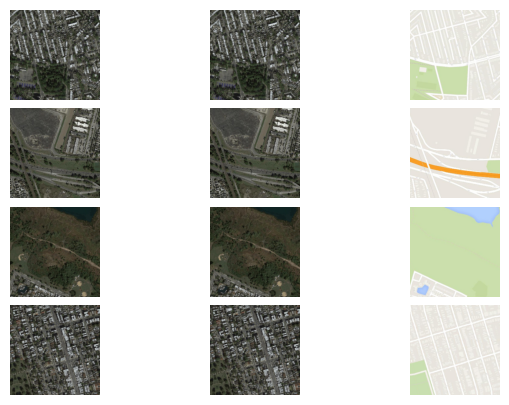

In [10]:
images = next(iter(dataloader_valid))
left_images, right_images = images
print(left_images.shape)
left_images = denormalize(left_images)
right_images = denormalize(right_images)
show_images3(left_images,left_images, right_images)

In [11]:
gc.collect()
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [12]:
import torch
import torch.nn as nn

class ContentEncoder(nn.Module):
    def __init__(self):
        super(ContentEncoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skip1 = self.conv1(x)
        skip2 = self.conv2(skip1)
        skip3 = self.conv3(skip2)
        return skip3, skip1, skip2

class StyleEncoder(nn.Module):
    def __init__(self):
        super(StyleEncoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(256 + 128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(128 + 64, 64, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, content, style, skip1, skip2):
        combined = torch.cat((content, style), dim=1)
        up1 = self.upconv1(combined)
        up1 = torch.cat((up1, skip2), dim=1)
        up2 = self.upconv2(up1)
        up2 = torch.cat((up2, skip1), dim=1)
        up3 = self.upconv3(up2)
        return self.final_conv(up3)

class SAMGANGenerator(nn.Module):
    def __init__(self):
        super(SAMGANGenerator, self).__init__()
        self.content_encoder = ContentEncoder()
        self.style_encoder1 = StyleEncoder()
        self.style_encoder2 = StyleEncoder()
        self.style_encoder3 = StyleEncoder()
        self.style_encoder4 = StyleEncoder()
        self.decoder = Decoder()

    def forward(self, x):
        content, skip1, skip2 = self.content_encoder(x)
        style1 = self.style_encoder1(right_images_np[0])
        style2 = self.style_encoder2(right_images_np[1])
        style3 = self.style_encoder3(right_images_np[2])
        style4 = self.style_encoder4(right_images_np[3])
        final_style = (style1 + style2 + style3 + style4) / 4
        return self.decoder(content, final_style, skip1, skip2)

class MultiScaleDiscriminator(nn.Module):
    def __init__(self):
        super(MultiScaleDiscriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.layers(x)


In [13]:
# Instantiate models
generator_sat_to_map = SAMGANGenerator().to(device)
discriminator_sat_to_map = MultiScaleDiscriminator().to(device)
# generator_map_to_sat = SAMGANGenerator().to(device)
# discriminator_map_to_sat = MultiScaleDiscriminator().to(device)
# Define loss functions and optimizers
criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss()
# Define optimizers
optimizer_G_sat_to_map = optim.Adam(generator_sat_to_map.parameters(), lr=0.0002, betas=(0.9, 0.999))
optimizer_D_sat_to_map = optim.Adam(discriminator_sat_to_map.parameters(), lr=0.0002, betas=(0.9, 0.999))

# Define learning rate schedulers
scheduler_G_sat_to_map = optim.lr_scheduler.StepLR(optimizer_G_sat_to_map, step_size=50, gamma=0.5)
scheduler_D_sat_to_map = optim.lr_scheduler.StepLR(optimizer_D_sat_to_map, step_size=50, gamma=0.5)

# optimizer_G_map_to_sat = optim.Adam(generator_sat_to_map.parameters(), lr=0.0002, betas=(0.9, 0.999))
# optimizer_D_map_to_sat = optim.Adam(discriminator_sat_to_map.parameters(), lr=0.0002, betas=(0.9, 0.999))

In [14]:

save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)
def save_models(generator_sat_to_map, discriminator_sat_to_map,generator_map_to_sat, discriminatoar_map_to_sat, prefix="models"):
    torch.save(generator_sat_to_map.state_dict(), f'{prefix}SAM_GAN_generator_sat_to_map.pth')
    torch.save(discriminator_sat_to_map.state_dict(), f'{prefix}discriminatoar_sat_to_map.pth')

    torch.save(generator_map_to_sat.state_dict(), f'{prefix}SAM_GAN_generator_map_to_sat.pth')
    torch.save(discriminatoar_map_to_sat.state_dict(), f'{prefix}discriminatoar_map_to_sat.pth')


In [18]:
generator_sat_to_map_path = os.path.join("models", 'prefixSAM_GAN_generator_sat_to_map.pth')
discriminatoar_sat_to_map_path = os.path.join('models', 'prefixdiscriminatoar_sat_to_map.pth')

generator_map_to_sat_path = os.path.join('', 'SAM_GAN_generator_map_to_sat.pth')
discriminatoar_map_to_sat_path = os.path.join('', 'discriminatoar_map_to_sat.pth')

if os.path.exists(generator_sat_to_map_path):
    generator_sat_to_map.load_state_dict(torch.load(generator_sat_to_map_path, map_location=torch.device('cpu')))
    print(f"Loaded generator_sat_to_map from {generator_sat_to_map_path}")
else:
    print("No generator checkpoint found, starting from scratch.")

if os.path.exists(discriminatoar_sat_to_map_path):
    discriminator_sat_to_map.load_state_dict(torch.load(discriminatoar_sat_to_map_path, map_location=torch.device('cpu')))
    print(f"Loaded discriminator from {discriminatoar_sat_to_map_path}")
else:
    print("No SAM_GAN_discriminatoar checkpoint found, starting from scratch.")

if os.path.exists(generator_map_to_sat_path):
    generator_sat_to_map.load_state_dict(torch.load(generator_map_to_sat_path, map_location=torch.device('cpu')))
    print(f"Loaded generator_sat_to_map from {generator_map_to_sat_path}")
else:
    print("No generator checkpoint found, starting from scratch.")

if os.path.exists(discriminatoar_map_to_sat_path):
    discriminator_sat_to_map.load_state_dict(torch.load(discriminatoar_map_to_sat_path, map_location=torch.device('cpu')))
    print(f"Loaded discriminator from {discriminatoar_map_to_sat_path}")
else:
    print("No SAM_GAN_discriminatoar checkpoint found, starting from scratch.")


Loaded generator_sat_to_map from models/prefixSAM_GAN_generator_sat_to_map.pth
Loaded discriminator from models/prefixdiscriminatoar_sat_to_map.pth
No generator checkpoint found, starting from scratch.
No SAM_GAN_discriminatoar checkpoint found, starting from scratch.


In [19]:
import gc
import torchvision.utils as vutils
def save_images(real_A, generated_images, real_B, filename):
    # Stack images along the batch dimension
    all_images = torch.cat((real_A, generated_images, real_B), 0)
    # Create a grid of images
    grid = vutils.make_grid(all_images, nrow=real_A.size(0), padding=2, normalize=True)
    # Save the grid
    vutils.save_image(grid, filename)

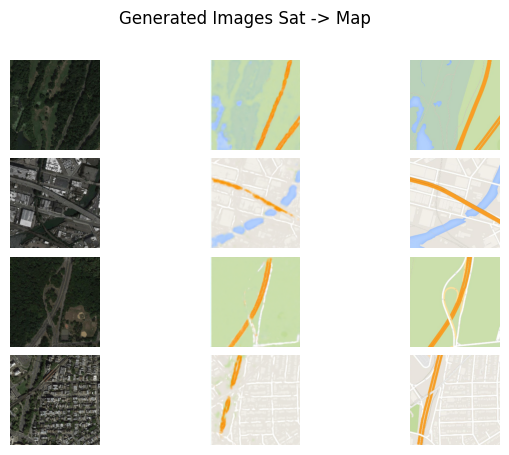

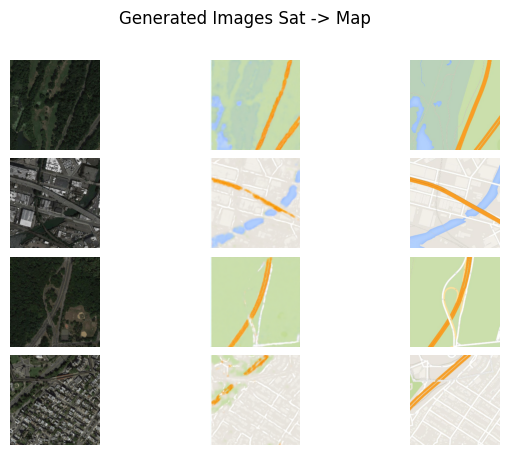

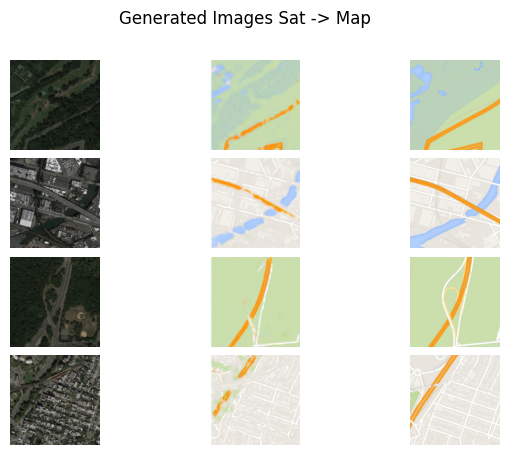

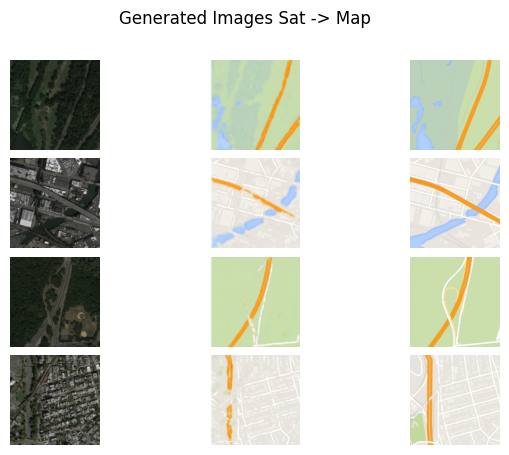

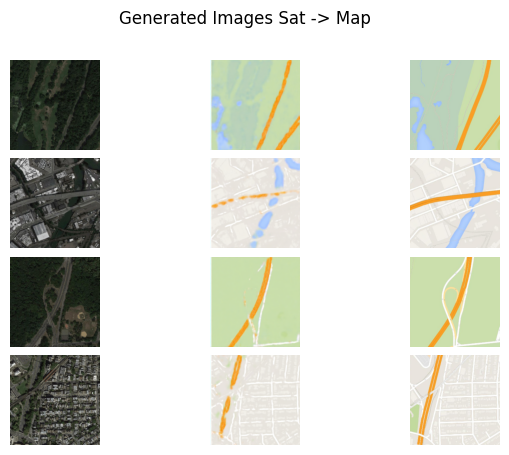

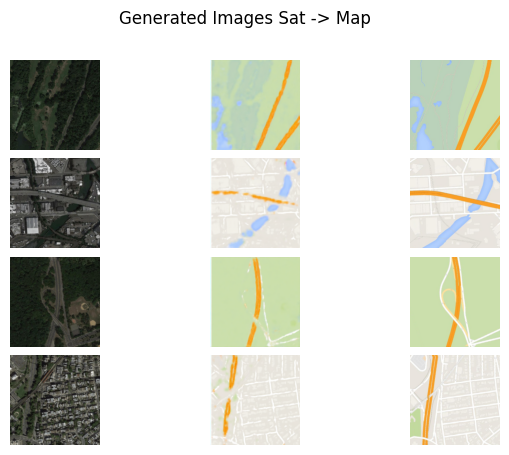

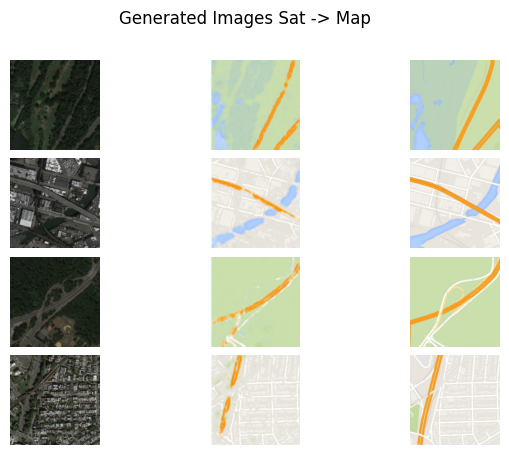

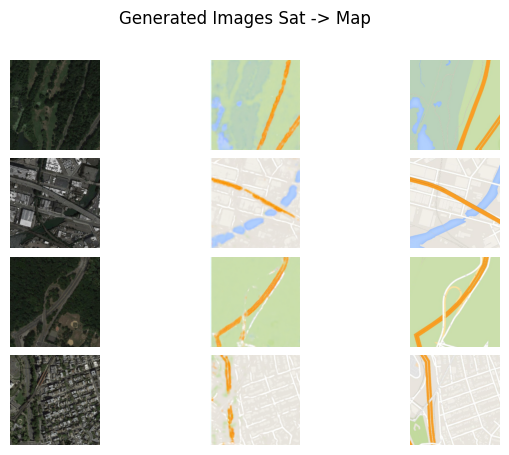

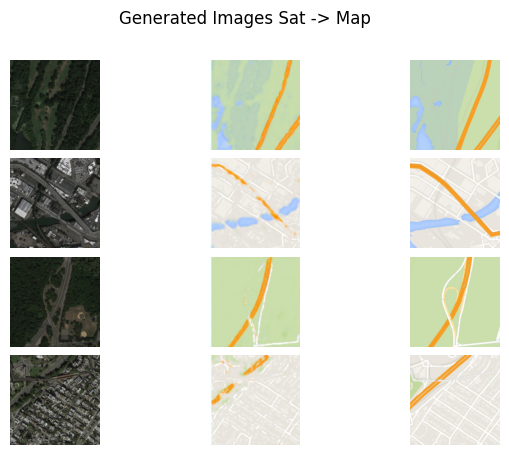

In [ ]:
num_epochs = 200
for epoch in range(199,num_epochs+50):

    G_loss_acc_sat_to_map = 0
    D_loss_acc_sat_to_map = 0
    generator_sat_to_map.train()
    discriminator_sat_to_map.train()

    # G_loss_acc_map_to_sat = 0
    # D_loss_acc_map_to_sat  = 0
    # generator_map_to_sat.train()
    # discriminator_map_to_sat.train()
    for i, (left_img, right_img) in enumerate(dataloader_train):

        #sat to map
        left_img_sat_to_map = left_img.to(device)
        right_img_sat_to_map = right_img.to(device)
        # Train Generator
        optimizer_G_sat_to_map.zero_grad()
        fake_img = generator_sat_to_map(left_img_sat_to_map)
        pred_fake = discriminator_sat_to_map(fake_img)
        valid = torch.ones(pred_fake.size(), requires_grad=False).to(device)
        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_pixel = criterion_pixelwise(fake_img, right_img_sat_to_map)
        loss_G_sat_to_map = loss_GAN + 100 * loss_pixel
        loss_G_sat_to_map.backward()
        optimizer_G_sat_to_map.step()

        # Train Discriminator
        optimizer_D_sat_to_map.zero_grad()
        pred_real = discriminator_sat_to_map(right_img_sat_to_map)
        valid = torch.ones(pred_real.size(), requires_grad=False).to(device)
        loss_real = criterion_GAN(pred_real, valid)
        pred_fake = discriminator_sat_to_map(fake_img.detach())
        fake = torch.zeros(pred_fake.size(), requires_grad=False).to(device)
        loss_fake = criterion_GAN(pred_fake, fake)
        loss_D_sat_to_map = 0.5 * (loss_real + loss_fake)
        loss_D_sat_to_map.backward()
        optimizer_D_sat_to_map.step()

        # map to sat part

        # left_img_map_to_sat = left_img.to(device)
        # right_img_map_to_sat = right_img.to(device)

        # # Train Generator
        # optimizer_G_map_to_sat.zero_grad()
        # fake_img = generator_map_to_sat(right_img_map_to_sat)
        # pred_fake = discriminator_map_to_sat(fake_img)
        # valid = torch.ones(pred_fake.size(), requires_grad=False).to(device)
        # loss_GAN = criterion_GAN(pred_fake, valid)
        # loss_pixel = criterion_pixelwise(fake_img, left_img_map_to_sat)
        # loss_G_map_to_sat = loss_GAN + 100 * loss_pixel
        # loss_G_map_to_sat.backward()
        # optimizer_G_map_to_sat.step()

        # # Train Discriminator
        # optimizer_D_map_to_sat.zero_grad()
        # pred_real = discriminator_map_to_sat(left_img_map_to_sat)
        # valid = torch.ones(pred_real.size(), requires_grad=False).to(device)
        # loss_real = criterion_GAN(pred_real, valid)
        # pred_fake = discriminator_map_to_sat(fake_img.detach())
        # fake = torch.zeros(pred_fake.size(), requires_grad=False).to(device)
        # loss_fake = criterion_GAN(pred_fake, fake)
        # loss_D_map_to_sat = 0.5 * (loss_real + loss_fake)
        # loss_D_map_to_sat.backward()
        # optimizer_D_map_to_sat.step()


    # generator_sat_to_map.eval()
    # generator_map_to_sat.eval()
    # if epoch %10 :
    #   with torch.no_grad():
    #       #eval part
    #               #saving model part
    #       torch.save(generator_sat_to_map.state_dict(), generator_sat_to_map_path)
    #       torch.save(discriminator_sat_to_map.state_dict(), discriminatoar_sat_to_map_path)

    #       # torch.save(generator_map_to_sat.state_dict(), generator_map_to_sat_path)
    #       # torch.save(discriminator_map_to_sat.state_dict(), discriminatoar_map_to_sat_path)

    #       images = next(iter(dataloader_valid))
    #       left_images, right_images = images

    #       right_fake_sat_to_map = denormalize(generator_sat_to_map(left_images.to(device)))
    #       left_images_sat_to_map = denormalize(left_images.cpu())

    #       # left_fake_map_to_sat = denormalize(generator_map_to_sat(right_images.to(device)))
    #       # left_images_map_to_sat = denormalize(left_images.cpu())

    #       #showing results part
    #       print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader_train)}] [D loss: {loss_D_sat_to_map.item()}] [G loss: {loss_G_sat_to_map.item()}]")

    #       # show_images3(right_images, left_fake_map_to_sat.cpu(),  denormalize(left_images), title="Generated Images  Map -> Sat ")
    #       # print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader_train)}] [D loss: {loss_D_map_to_sat.item()}] [G loss: {loss_G_map_to_sat.item()}]")
    #       #saving images part
        torch.save(generator_sat_to_map.state_dict(), f'{"prefix"}SAM_GAN_generator_sat_to_map.pth')
        torch.save(discriminator_sat_to_map.state_dict(), f'{"prefix"}discriminatoar_sat_to_map.pth')
        if i == 27 and epoch %2 == 0:
          generator_sat_to_map.eval()
          with torch.no_grad():
              generated_images = generator_sat_to_map(left_img_sat_to_map)
              # Optionally, save these images to disk
              show_images3(denormalize(left_img_sat_to_map.cpu()), denormalize(generated_images.cpu()), right_img_sat_to_map.cpu(), title="Generated Images Sat -> Map")

              save_images(denormalize(left_img_sat_to_map.cpu()), denormalize(generated_images.cpu()), right_img_sat_to_map.cpu(), f"epoch_{epoch}_last_batch.png")
    scheduler_G_sat_to_map.step()
    scheduler_D_sat_to_map.step()

In [ ]:
torch.cuda.empty_cache()